In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Text(0, 0.5, 'Objective 2')

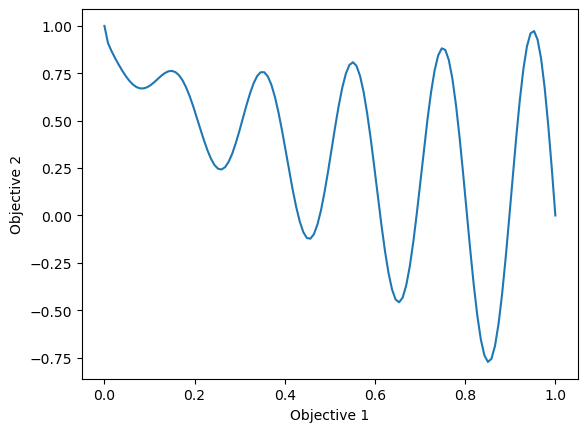

In [2]:
# ZDT3
def zdt3_opt(x): 
    return 1 - np.sqrt(x) - x * np.sin(10 * np.pi * x)

x = np.linspace(0, 1, 128)
y = zdt3_opt(x)
plt.plot(x, y)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")

Text(0, 0.5, 'Objective 2')

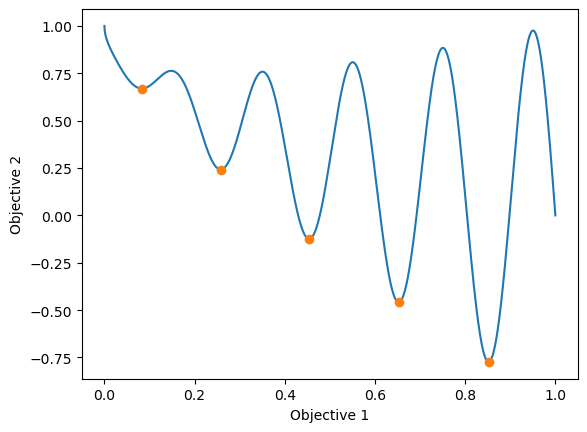

In [3]:
# To divide into non-dominated sets, find the minima of the second objective function
# Due to complexity of the function, do this numerically, starting with good guesses of minima
def make_guesses(fun, npoints):
    x = np.linspace(0, 1, npoints)
    y = fun(x)
    yprime = np.diff(y)
    yprimeprime = np.diff(yprime)

    # Get guesses for the zeros
    epsilon = 2/npoints
    zero_guesses = np.bitwise_and(np.abs(yprime[:-1]) < epsilon, yprimeprime > 0)

    # Merge "blobs" into single points
    blobs = [[]]
    for idx, g in enumerate(zero_guesses):
        if not g and len(blobs[-1]):
            blobs.append([])
        if g:
            blobs[-1].append(x[idx])
    return [(b[0] + b[-1])/2 for b in blobs[:-1]]

def get_minima(fun, npoints):
    return np.array([minimize(fun, guess, bounds=[[guess*0.9, guess*1.1]], tol=1e-13).x[0] for guess in  make_guesses(fun, npoints)])

x = np.linspace(0, 1, 2048)
y = zdt3_opt(x)
minima = get_minima(zdt3_opt, 2048)
plt.plot(x, y)
plt.plot(minima, zdt3_opt(minima), marker='o', ls='none')
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")

Text(0, 0.5, 'Objective 2')

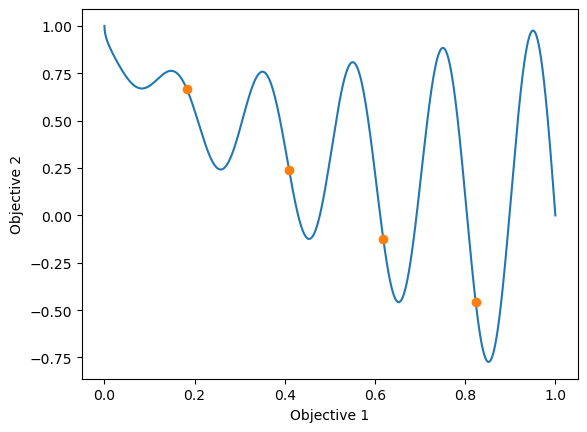

In [4]:
# Also need the point where the function's minima intersects the right hand side of the next curve of the function
def get_intercepts(fun, npoints, minima):
    intercepts = []
    for reg_start, reg_stop in zip(minima, minima[1:]):
        x = np.linspace(reg_start + (reg_stop - reg_start)*0.1, reg_stop, npoints)
        guess = x[np.argmin((fun(x) - fun(reg_start))**2)]
        #intercepts.append(guess)
        intercepts.append(minimize(lambda x: (fun(x) - fun(reg_start))**2, guess, bounds=[[reg_start + (reg_stop - reg_start)*0.1, reg_stop]], tol=1e-13).x[0])
    return np.array(intercepts)

intercepts = get_intercepts(zdt3_opt, 2048, minima)
x = np.linspace(0, 1, 2048)
y = zdt3_opt(x)
plt.plot(x, y)
plt.plot(intercepts, zdt3_opt(intercepts), marker='o', ls='none')
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")

[(0, 0.08300152991598536),
 (0.18222872351573624, 0.25776236490626825),
 (0.4093136698086569, 0.453882099086383),
 (0.6183967894392438, 0.6525116988130034),
 (0.8233317933269128, 0.851832862382744)]

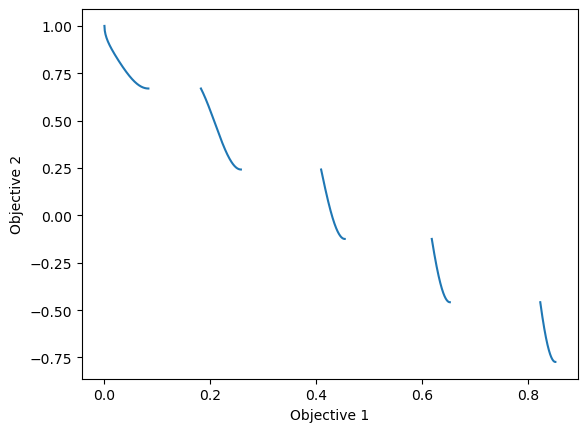

In [5]:
# Combine everything together to get the nondominated ranges
def get_nondominated_ranges(fun, npoints):
    minima = get_minima(fun, npoints)
    intercepts = get_intercepts(fun, npoints, minima)
    return list(zip([0] + intercepts.tolist(), minima))

regs = get_nondominated_ranges(zdt3_opt, 2048)
for reg in regs:
    x = np.linspace(*reg, 128)
    y = zdt3_opt(x)
    plt.plot(x, y, c='C0')
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
regs

Text(0, 0.5, 'Objective 2')

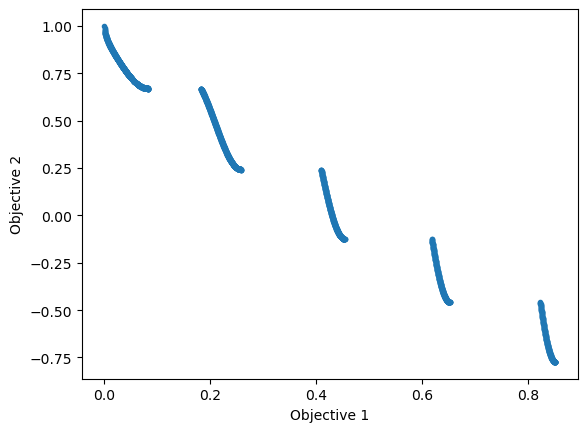

In [6]:
# Turn the ranges into something that evaluates the actualy Pareto front
def weighted_chunk_sizes(n, weights):
    ns = [int(np.floor(n*w/sum(weights))) for w in weights]
    for i in range(32):
        if sum(ns) < n:
            ns[i%len(ns)] += 1
        else:
            break
    return ns

regs = [
    (0.0, 0.08300152991598536),
    (0.18222872351573624, 0.25776236490626825),
    (0.4093136698086569, 0.453882099086383),
    (0.6183967894392438, 0.6525116988130034),
    (0.8233317933269128, 0.851832862382744)
]

n = 2048
# Evaluate along each discrete region
f = []
for r, my_n in zip(regs, weighted_chunk_sizes(n, [r[1] - r[0] for r in regs])):
    x = np.linspace(*r, my_n)
    f.append([x, 1 - np.sqrt(x) - x*np.sin(10*np.pi*x)])
f = np.concatenate(f, axis=1)

plt.plot(f[0], f[1], marker='.', ls='none')
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")